# **Integration and annotation of single-nuclei RNA-seq data from all SenNet human lung tissue donors**

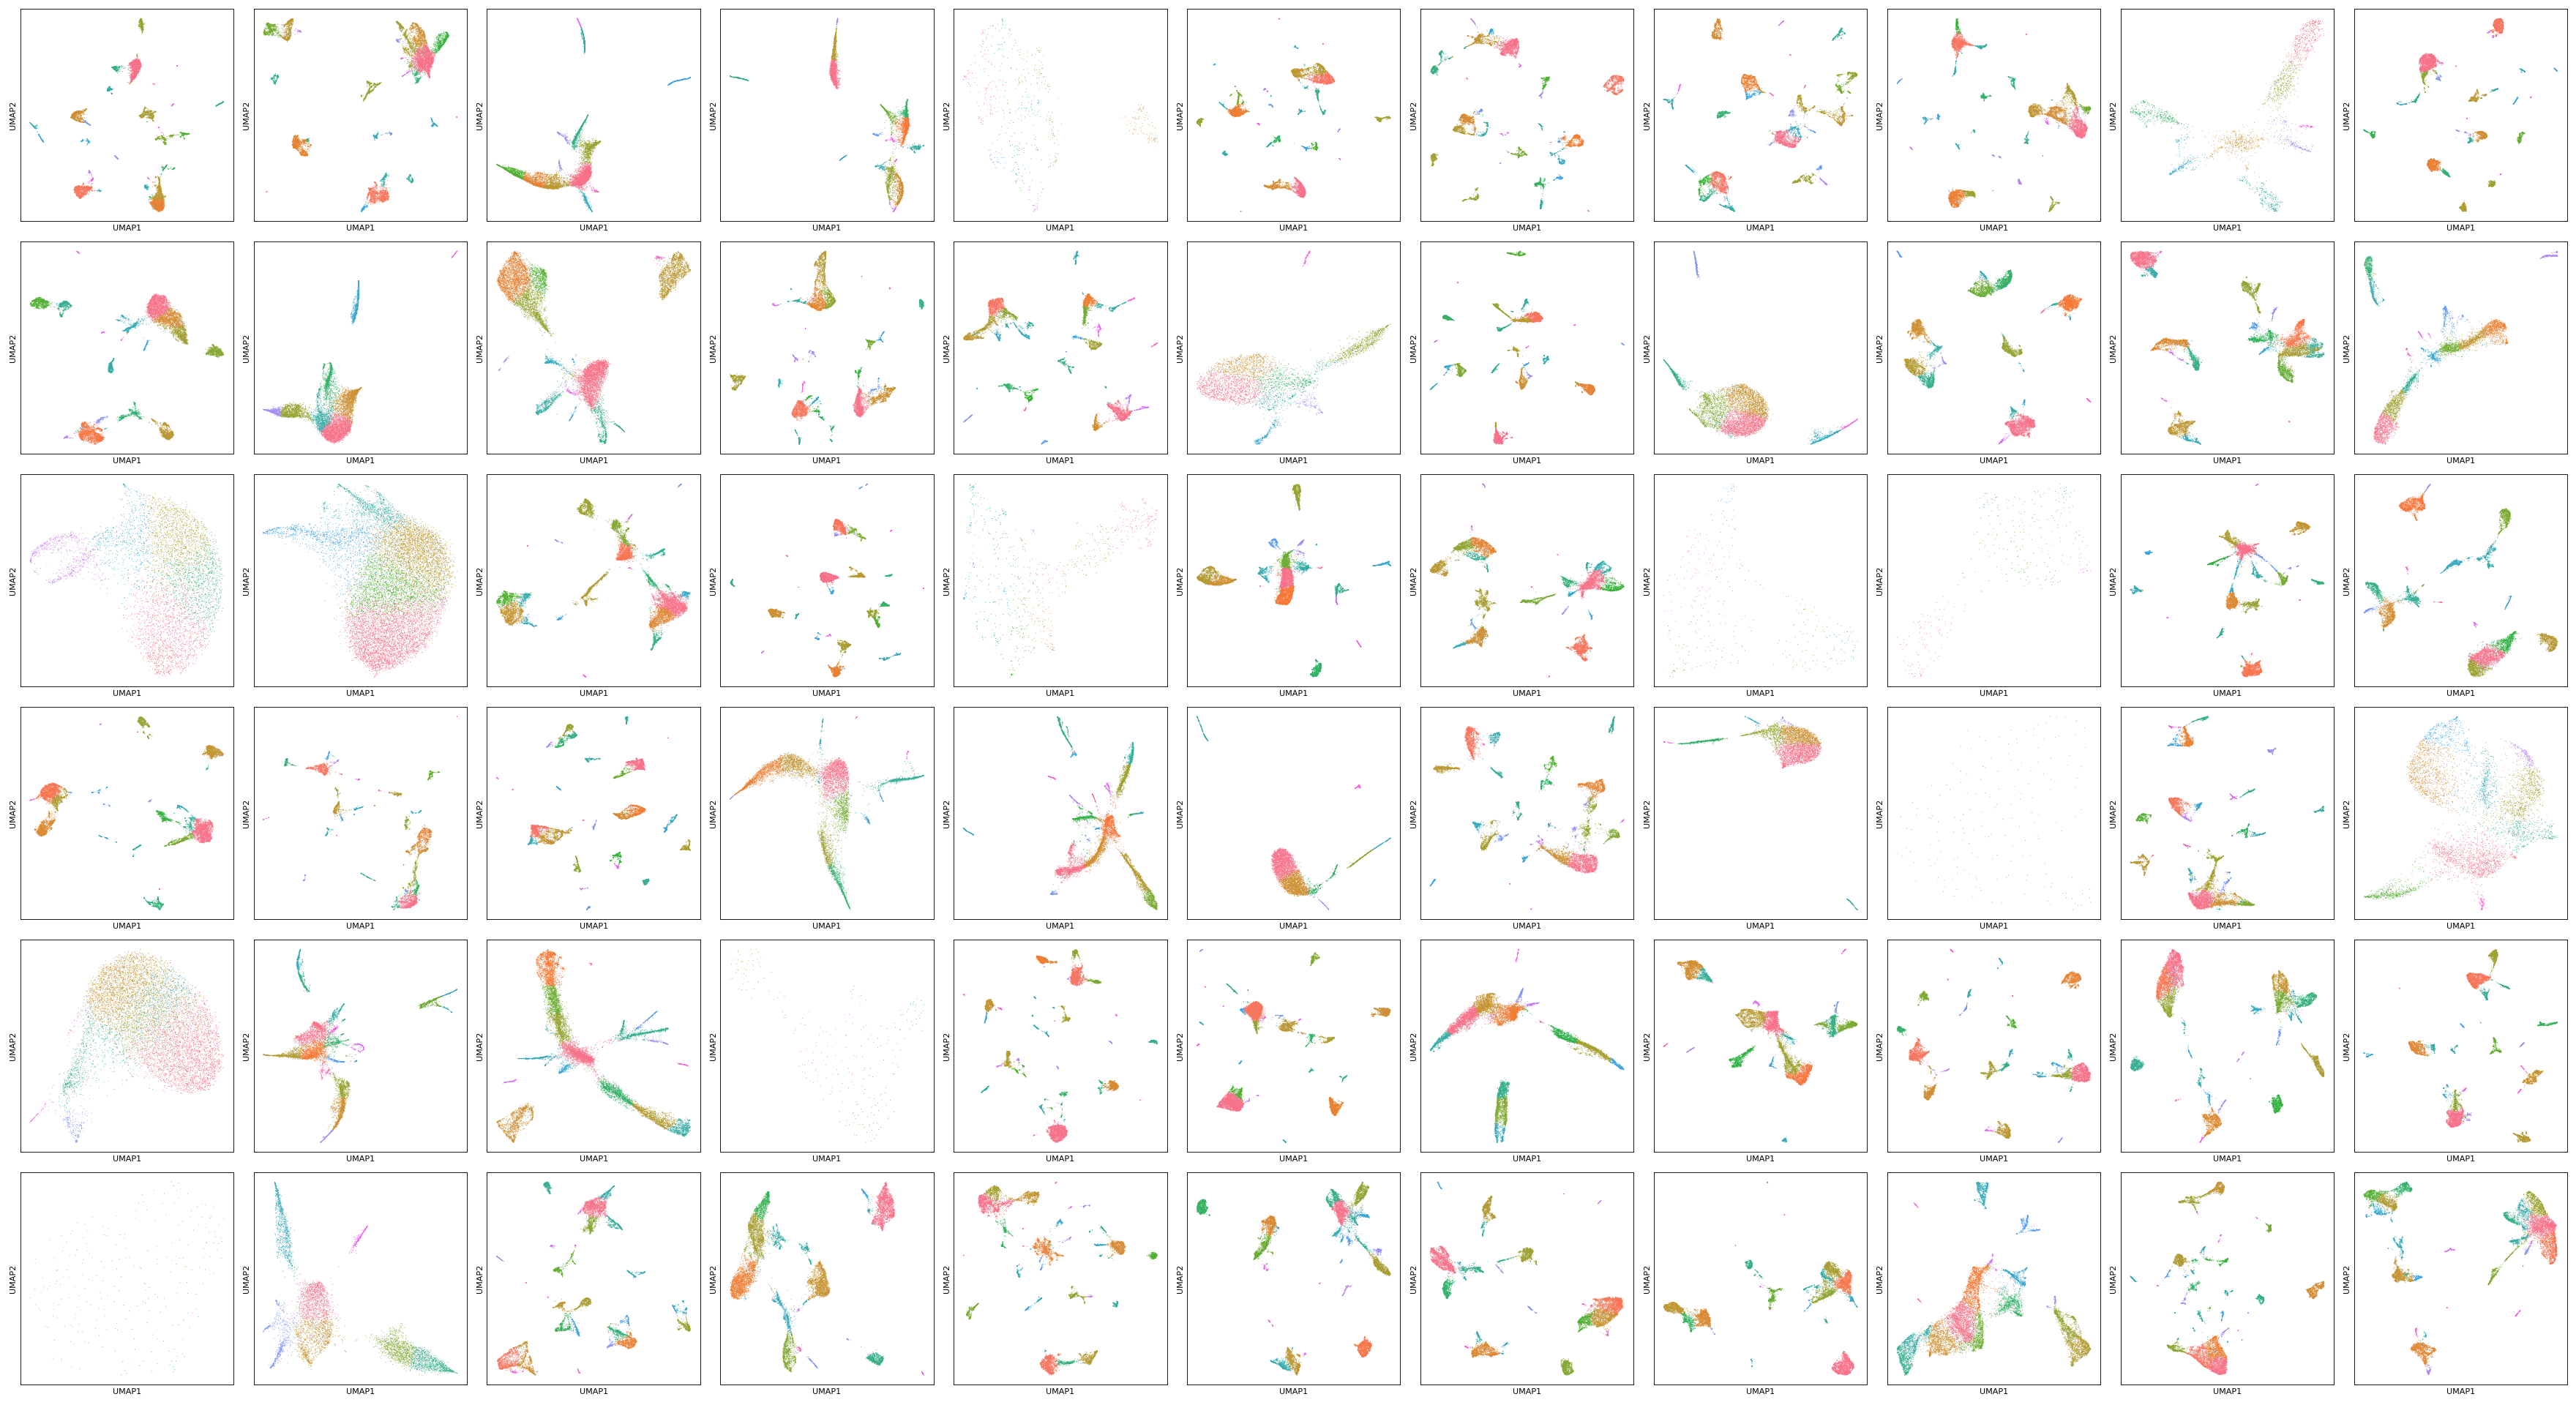

#### This vignette demonstrates how to 1) query the SenNet database for available human liver single-nucleus RNA-sequencing datasets, 3) pre-process and integrate data, and 4) annotate cell types using marker genes derived from the Panglao database.

## ***<u>Part 1. Finding the datasets and formatting the metadata.</u>***

#### Using `requests`, the function below handles response codes specific to the SenNet Search API.

In [1]:
import requests

def get_sennet_datasets(criteria):

    '''
    Uses the SenNet Search API and RESTful search criteria using the requests library.

    Usage:
            datasets = get_sennet_datasets(criteria)

    Criteria must be a dictionary with dataset attribute fields as keys and attribute entries as values.

    For examples of criteria, please see https://docs.sennetconsortium.org/param-search/schema-dataset.html.
    '''

    url = 'https://search.api.sennetconsortium.org/param-search/datasets'
    
    try:
        response = requests.get(url, criteria)
    except Error as e:
        print(f"Could not complete request: {e}")
        raise
    
    if response.status_code == 200:
        try:
            datasets = response.json()
            print(f"Successfully found {len(datasets)} matching entries.")
        except Error as e:
            print(f"Error occurred with response code {response.status_code}: {e}")
            raise
            
    elif response.status_code == 303:
        try:
            new_response = requests.get(response.text)
            if new_response.status_code == 200:
                try:
                    datasets = new_response.json()
                    print(f"Successfully found {len(datasets)} matching entries.")
                except Error as e:
                    print(f"Error occurred with response code {new_response.status_code}: {e}")
                    raise
        except Error as e:
            print(f"Error occurred with response code {response.status_code}: {e}")
            raise
            
    elif response.status_code == 404:
        print(f"Response code: {response.status_code}. No results found.")
        raise
        
    elif response.status_code == 504:
        print(f"Response code: {response.status_code}. Query timed out (30 seconds).")
        raise
        
    else:
        print(f"Unknown error occurred.")
        raise
    return datasets

#### Define the criteria needed to pull out single-nucleus RNA-sequencing datasets derived from human liver.

#### Note that later schema versions may not include a `metadata.assay_input_entity` field. For such data, a similar request can be made with the key-value pair `'data_types': 'snRNA-seq'` instead of `'metadata.assay_input_entity': 'single nucleus'`.

In [2]:
criteria = {
    'origin_samples.organ_hierarchy': 'Lung',
    'sources.source_type': 'Human',
    'dataset_type': 'RNAseq',
    'metadata.assay_input_entity': 'single nucleus'
}

datasets = get_sennet_datasets(criteria)

Successfully found 66 matching entries.


#### Using `pandas`, we can clean up the resulting assay and source metadata matches into a nicer format.

In [3]:
import pandas as pd

#### Make an emtpy `pandas` dataframe to hold metadata, first adding in the assay and dataset metadata. Use the dataset `uuid` as the index.

In [4]:
metadata = pd.DataFrame(index=range(len(datasets)))

#### Then add in metadata for each dataset, including assay metadata and source metadata

In [5]:
for i, dataset in enumerate(datasets):

    # First add in dataset metadata:

    for id_field in ['uuid', 'sennet_id', 'group_name']:
        if id_field in metadata.columns:
            metadata.loc[i, id_field] = dataset[id_field]
        elif id_field not in metadata.columns:
            metadata[id_field] = ''
            metadata.loc[i, id_field] = dataset[id_field]
    
    for assay_field, value in dataset['metadata'].items():
        if assay_field in metadata.columns:
            metadata.loc[i, assay_field] = value
        elif assay_field not in metadata.columns:
            metadata[assay_field] = ''
            metadata.loc[i, assay_field] = value

    # Then add in source metadata, which is organized by grouping concepts for human source metadata:

    donor_type = list(dataset['sources'][0]['metadata'].keys())[0]

    if 'donor_type' in metadata.columns:
        metadata.loc[i, 'donor_type'] = donor_type
    elif 'donor_type' not in metadata.columns:
        metadata['donor_type'] = ''
        metadata.loc[i, 'donor_type'] = donor_type    

    for entry in dataset['sources'][0]['metadata'][donor_type]:
        
        if entry['units'] == '':
            source_field = entry['grouping_concept_preferred_term']
        elif entry['units'] != '':
            source_field = f"{entry['grouping_concept_preferred_term']} ({entry['units']})"

        # For some fields in some datasets, the data value is actually stored in 'preferred_term'
        
        if entry['data_value'] != entry['grouping_concept_preferred_term']:
            data_value = entry['data_value']
        elif entry['data_value'] == entry['grouping_concept_preferred_term']:
            data_value = entry['preferred_term']
        
        if source_field in metadata.columns:
            metadata.loc[i, source_field] = data_value
        elif source_field not in metadata.columns:
            metadata[source_field] = ''
            metadata.loc[i, source_field] = data_value

metadata.set_index('uuid', inplace=True)

metadata

sennet_id  \
uuid                                                
445be81ec02cebc7d9a83e63317be937  SNT867.PMJD.853   
0c70552e21f1833533855fc6d22ecdd6  SNT397.SPGW.436   
a7799ef1131293a5e115ecc4aa7295ce  SNT467.NJWW.933   
c4ae7c9526b825304dfa93bbc51acd33  SNT658.LQWB.482   
57a17d129a7587153d8f9ac160fac40f  SNT577.KHFG.572   
...                                           ...   
9e38a62ecb941eb541b37aa1b6f20d1c  SNT479.PCMQ.829   
74a79491a450af998394c264938a7230  SNT593.SCSG.422   
24c43659abc2913d65060fbc63447efc  SNT759.KMJC.586   
ebbfe361118792effb14ebb3d72f552c  SNT587.CNQX.768   
fbe1d54ad9a829e2f2e45f91f0ccda25  SNT887.TMFM.723   

                                                      group_name  \
uuid                                                               
445be81ec02cebc7d9a83e63317be937  TMC - University of Pittsburgh   
0c70552e21f1833533855fc6d22ecdd6  TMC - University of Pittsburgh   
a7799ef1131293a5e115ecc4aa7295ce  TMC - University of Pittsburgh   
c4ae7c9526b825304dfa93bbc51acd33  TMC - University of Pittsburgh   
57a17d129a7587153d8f9ac160fac40f  TMC - University of Pittsburgh   
...                                                          ...   
9e38a62ecb941eb541b37aa1b6f20d1c  TMC - University of Pittsburgh   
74a79491a450af998394c264938a7230  TMC - University of Pittsburgh   
24c43659abc2913d65060fbc63447efc  TMC - University of Pittsburgh   
ebbfe361118792effb14ebb3d72f552c  TMC - University of Pittsburgh   
fbe1d54ad9a829e2f2e45f91f0ccda25  TMC - University of Pittsburgh   

                                 acquisition_instrument_model  \
uuid                                                            
445be81ec02cebc7d9a83e63317be937                 NovaSeq 6000   
0c70552e21f1833533855fc6d22ecdd6                 NovaSeq 6000   
a7799ef1131293a5e115ecc4aa7295ce                 NovaSeq 6000   
c4ae7c9526b825304dfa93bbc51acd33                 NovaSeq 6000   
57a17d129a7587153d8f9ac160fac40f                 NovaSeq 6000   
...                                                       ...   
9e38a62ecb941eb541b37aa1b6f20d1c                 NovaSeq 6000   
74a79491a450af998394c264938a7230                    NovaSeq X   
24c43659abc2913d65060fbc63447efc                    NovaSeq X   
ebbfe361118792effb14ebb3d72f552c                    NovaSeq X   
fbe1d54ad9a829e2f2e45f91f0ccda25                    NovaSeq X   

                                 acquisition_instrument_vendor  \
uuid                                                             
445be81ec02cebc7d9a83e63317be937                      Illumina   
0c70552e21f1833533855fc6d22ecdd6                      Illumina   
a7799ef1131293a5e115ecc4aa7295ce                      Illumina   
c4ae7c9526b825304dfa93bbc51acd33                      Illumina   
57a17d129a7587153d8f9ac160fac40f                      Illumina   
...                                                        ...   
9e38a62ecb941eb541b37aa1b6f20d1c                      Illumina   
74a79491a450af998394c264938a7230                      Illumina   
24c43659abc2913d65060fbc63447efc                      Illumina   
ebbfe361118792effb14ebb3d72f552c                      Illumina   
fbe1d54ad9a829e2f2e45f91f0ccda25                      Illumina   

                                 amount_of_input_analyte_unit  \
uuid                                                            
445be81ec02cebc7d9a83e63317be937                                
0c70552e21f1833533855fc6d22ecdd6                                
a7799ef1131293a5e115ecc4aa7295ce                                
c4ae7c9526b825304dfa93bbc51acd33                                
57a17d129a7587153d8f9ac160fac40f                                
...                                                       ...   
9e38a62ecb941eb541b37aa1b6f20d1c                                
74a79491a450af998394c264938a7230                                
24c43659abc2913d65060fbc63447efc                                
ebbfe361118792effb14ebb3d72f552c             

#### The primary data provider for these datasets is the **University of Pittsburgh**, part of the Tri-State SenNet Tissue Mapping Center tasked with charting senescence in heart and lung tissue. Datasets may have slightly different metadata records.

#### Use `matplotlib` to visualize the demographics of the queried data sources.

In [6]:
import matplotlib.pyplot as plt

#### Create multiple subplots for categorical metadata and numerical metadata. 

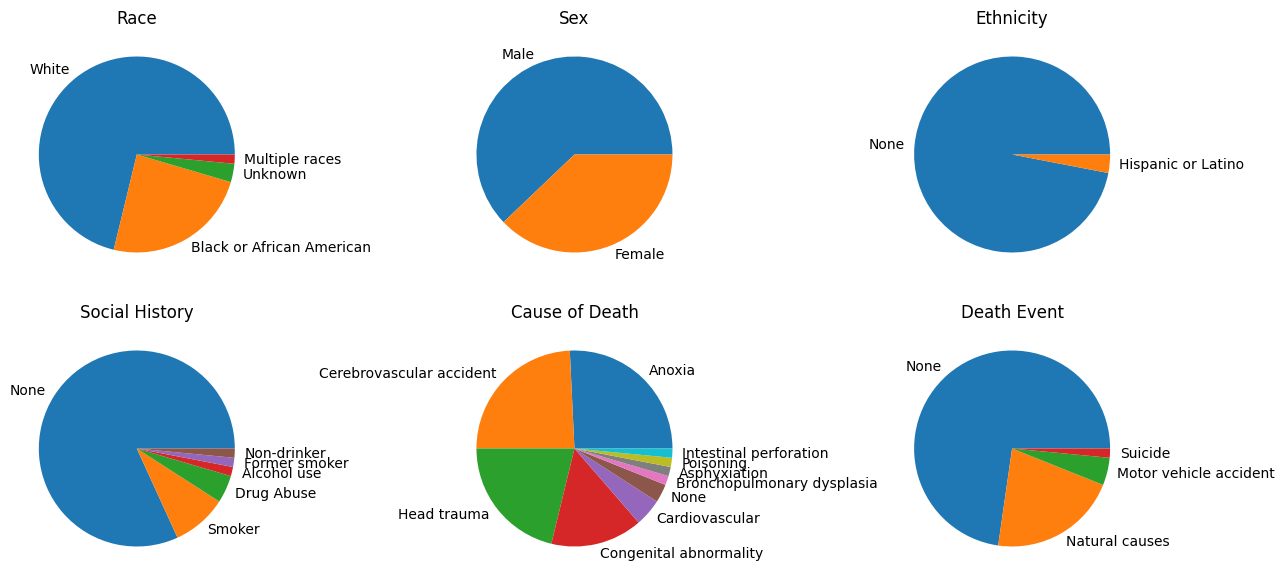

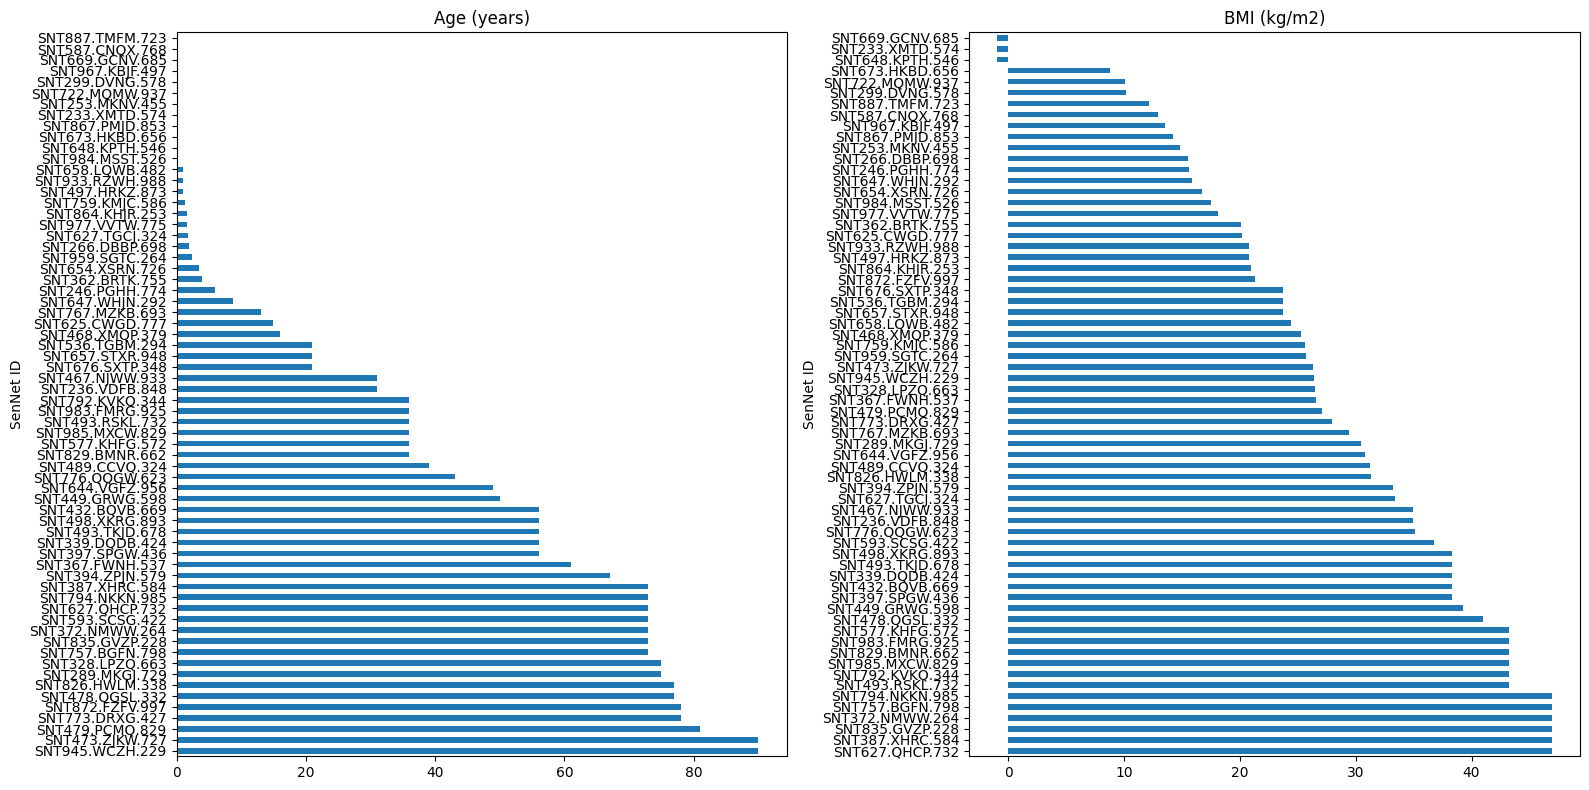

In [7]:
fig1, axs1 = plt.subplots(2, 3, figsize=(16,7)) # For categorical pie charts
fig2, axs2 = plt.subplots(1, 2, figsize=(16, 8)) # For numerical bargraphs

# Categorical metadata:

metadata['Race'].replace('', 'None').value_counts().plot(kind='pie', ylabel='', title='Race', ax=axs1[0,0])
metadata['Sex'].replace('', 'None').value_counts().plot(kind='pie', ylabel='', title='Sex', ax=axs1[0,1])
metadata['Ethnicity'].replace('', 'None').value_counts().plot(kind='pie', ylabel='', title='Ethnicity', ax=axs1[0,2])
metadata['Social History'].replace('', 'None').value_counts().plot(kind='pie', ylabel='', title='Social History', ax=axs1[1,0])
metadata['Cause of Death'].replace('', 'None').value_counts().plot(kind='pie', ylabel='', title='Cause of Death', ax=axs1[1,1])
metadata['Death Event'].replace('', 'None').value_counts().plot(kind='pie', ylabel='', title='Death Event', ax=axs1[1,2])

# Numerical metadata:

sorted_age = metadata['Age (years)'].astype(float).sort_values(ascending=False)
sorted_age.plot(kind='barh', ax=axs2[0], title='Age (years)')
axs2[0].set_yticks(range(len(sorted_age)))
axs2[0].set_yticklabels(metadata.loc[sorted_age.index, 'sennet_id'])
axs2[0].set_ylabel('SenNet ID')

sorted_bmi = metadata['Body Mass Index (kg/m2)'].replace({'': -1}).astype(float).sort_values(ascending=False) # Replace missing values with -1
sorted_bmi.plot(kind='barh', ax=axs2[1], title='BMI (kg/m2)')
axs2[1].set_yticks(range(len(sorted_bmi)))
axs2[1].set_yticklabels(metadata.loc[sorted_bmi.index, 'sennet_id'])
axs2[1].set_ylabel('SenNet ID')

plt.tight_layout()
plt.show()
plt.close()

## ***<u>Part 2. Downloading datasets.<u/>***

#### With the associated metadata listed for all datasets, we can use the **raw dataset UUIDs** to find the download URL of the cell-by-gene matrixes (in the form of `expr.h5ad` files) for each dataset by querying raw dataset descendants in the SenNet Entity API.

In [8]:
entity_api_url = 'https://entity.api.sennetconsortium.org/descendants'

dataset_urls = {}

for uuid in metadata.index: # If the UUID is set to the metadata index
    response = requests.get(f"{entity_api_url}/{uuid}")
    dataset_url = f"https://assets.api.sennetconsortium.org/{response.json()[0]['uuid']}/expr.h5ad"
    dataset_urls[uuid] = dataset_url

metadata['expr_file_url'] = metadata.index.map(dataset_urls)

#### If desired, the SenNet Command Line Transfer (CLT) tool can be used to download datasets using UUIDs or SenNet IDs (see https://docs.sennetconsortium.org/libraries/clt/).

#### Use `os` and the previously imported `requests` to manipulate local directories and systematically download every human lung snRNA-seq dataset from the SenNet Assets API.

In [9]:
import os

#### At the time of this vignette's creation, there were 66 total datasets matching these criteria. The resulting total download size is **approximately 22 GB** and contains >700,000 nuclei and >60,000 trancript IDs.

In [10]:
for uuid, url in dict(zip(metadata.index, metadata.expr_file_url)).items():
    dir_path = f"lung-single-nuc-data/{uuid}"
    filename = f"{dir_path}/expr.h5ad"
    
    try:
    # Try to create directory for the current UUID in the loop
        os.makedirs(dir_path, exist_ok=False)
    # If the directory already exists: 
    except FileExistsError:
        # List its contents
        files = os.listdir(dir_path)
        # If it already has expr.h5ad, skip it:
        if 'expr.h5ad' in files:
            print(f"Directory {uuid} already exists and contains 'expr.h5ad'. Skipping...")
            continue
        # If it does not have expr.h5ad, proceed to download:
        else:
            print(f"Directory {uuid} already exists. Downloading 'expr.h5ad'...")

    try:
        download_response = requests.get(url, stream=True, timeout=(60, 300))
        download_response.raise_for_status()
        with open(filename, 'wb') as f:
            for chunk in download_response.iter_content(chunk_size=8192):
                f.write(chunk)
    except Exception as e:
        print(f"Download failed for {uuid}: {e}")

#### Each downloaded `expr.h5ad` file will be located in `~/lung-single-nuc-data/{primary-dataset-uuid}/`.

#### Datasets can be read into AnnData format with `anndata` or `scanpy`.

## ***<u>Part 3. Pre-processing and integration.<u/>***

#### `scanpy` is a wrapper for `anndata` useful for many types of single-cell and single-nucleus RNA-seq analysis.

In [11]:
import scanpy as sc

#### ⚠️ WARNING ⚠️ Reading in every downloaded dataset in full is memory-intensive, particularly if new counts layers are created or sparse data is densified. This analysis should ideally be done in a high-performance, high-RAM computing environment.

In [12]:
adatas = {} # An empty dictionary to hold AnnData objects for each donor dataset

for uuid in os.listdir('lung-single-nuc-data'):
    adatas[uuid] = sc.read_h5ad(f"lung-single-nuc-data/{uuid}/expr.h5ad")

#### For every dataset, add in its corresponding metadata associated with both the dataset and source.

In [13]:
for adat in adatas.keys():
    
    # Convert to string:
    
    adatas[adat].obs['uuid'] = str(adat)
    
    # Merge on UUID
    
    adatas[adat].obs = pd.merge(adatas[adat].obs, metadata, left_on='uuid', right_index=True, how='inner')
    
    # Rename the indices of adata.var to the common HGNC nomenclature, replacing nan values with the Ensembl ID:
    
    adatas[adat].var['Ensembl_ID'] = list(adatas[adat].var_names)
    adatas[adat].var['display_name'] = adatas[adat].var['hugo_symbol'].astype(str).replace('nan', pd.NA).fillna(pd.Series(adatas[adat].var.index, index=adatas[adat].var.index))
    adatas[adat].var.set_index('display_name', drop=True, inplace=True)
    adatas[adat].var_names_make_unique()
    

/users/9/stpeters/.conda/envs/sennet-demo-env/lib/python3.9/site-packages/anndata/utils.py:261: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(
/users/9/stpeters/.conda/envs/sennet-demo-env/lib/python3.9/site-packages/anndata/utils.py:261: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(
/users/9/stpeters/.conda/envs/sennet-demo-

#### Concatenate the datasets from the dictionary into one AnnData object.

In [14]:
import anndata as ad

adata = ad.concat(list(adatas.values()), join='outer', label='batch', index_unique='-', keys=list(range(0, len(adatas.keys()))), merge='unique')
# Using the 'spliced' layer will only conts mature RNA transcripts in the analysis.
adata.X = adata.layers['spliced'].copy()
# Other types of analysis outside the scope of this vignette, such as RNA velocity, can be done using the unspliced counts matrix

#### Low-quality cells tend to express high mitochondrial content, For quality control of cells, genes from the mitochondrial genome should be annotated. However, gene names may include gene aliases in addition to official nomenclature. The following dictionary and set are derived from HGNC resources (https://www.genenames.org/data/genegroup/#!/group/1972)

##### Note: It may also be beneficial to use doublet detection tools (e.g. `scrublet`) to remove probable multiplets from the data. Doublet detection is not done in this vignette.

In [15]:
mt_gene_aliases = {
    'MT-LIPCAR': ['uc022bqs.1', 'LIPCAR'],
    'MT-ATP6': ['MTATP6', 'RP', 'ATP6', 'ATPase-6', 'Su6m'],
    'MT-ATP8': ['MTATP8', 'ATP8', 'A6L', 'URFA6L'],
    'MT-CO1': ['MTCO1', 'COX1', 'COI'],
    'MT-CO2': ['MTCO2', 'COX2', 'CO2'],
    'MT-CO3': ['MTCO3', 'COX3', 'COIII', 'CO3'],
    'MT-CYB': ['MTCYB', 'COB', 'CYTB', 'UQCR3'],
    'MT-ND1': ['MTND1', 'ND1', 'NAD1'],
    'MT-ND2': ['MTND2', 'ND2', 'NAD2'],
    'MT-ND3': ['MTND3', 'ND3', 'NAD3'],
    'MT-ND4': ['MTND4', 'LHON', 'ND4', 'NAD4'],
    'MT-ND4L': ['MTND4L', 'ND4L', 'NAD4L'],
    'MT-ND5': ['MTND5', 'ND5', 'NAD5'],
    'MT-ND6': ['MTND6', 'NAD6', 'ND6'],
    'MT-ATT': ['MTATT'],
    'MT-CSB1': ['MTCSB1', 'CSB-I'],
    'MT-CSB2': ['MTCSB2', 'CSB-II'],
    'MT-CSB3': ['MTCSB3', 'CSB-III'],
    'MT-HPR': ['MTHPR', 'HPR'],
    'MT-HSP1': ['MTHSP1'],
    'MT-HSP2': ['MTHSP2'],
    'MT-LSP': ['MTLSP'],
    'MT-OHR': ['MTOHR'],
    'MT-OLR': ['MTOLR', 'OriL'],
    'MT-RNR3': ['MTRNR3'],
    'MT-TAS': ['MTTAS'],
    'MT-TER': ['MTTER'],
    'MT-TFH': ['MTTFH'],
    'MT-TFL': ['MTTFL'],
    'MT-TFX': ['MTTFX'],
    'MT-TFY': ['MTTFY'],
    'MT-7SDNA': ['MT7SDNA'],
    'MT-RNR1': ['MTRNR1', '12S', 'MOTS-c'],
    'MT-RNR2': ['MTRNR2', 'HN', '16S'],
    'MT-TA': ['MTTA', 'trnA'],
    'MT-TC': ['MTTC', 'trnC'],
    'MT-TD': ['MTTD', 'trnD'],
    'MT-TE': ['MTTE', 'trnE'],
    'MT-TF': ['MTTF', 'trnF'],
    'MT-TG': ['MTTG', 'trnG'],
    'MT-TH': ['MTTH', 'trnH'],
    'MT-TI': ['MTTI', 'trnI'],
    'MT-TK': ['MERRF', 'MTTK', 'trnK'],
    'MT-TL1': ['MTTL1', 'TRNL1'],
    'MT-TL2': ['MTTL2', 'TRNL2'],
    'MT-TM': ['MTTM', 'trnM'],
    'MT-TN': ['MTTN', 'trnN'],
    'MT-TP': ['MTTP', 'trnP'],
    'MT-TQ': ['MTTQ', 'trnQ'],
    'MT-TR': ['MTTR', 'trnR'],
    'MT-TS1': ['MTTS1', 'TRNS1'],
    'MT-TS2': ['MTTS2', 'TRNS2', 'RP8'],
    'MT-TT': ['MTTT', 'LIMM', 'trnT'],
    'MT-TV': ['MTTV', 'trnV'],
    'MT-TW': ['MTTW', 'trnW'],
    'MT-TY': ['MTTY', 'trnY']
}

mt_gene_set = set()
for symbol, aliases in mt_gene_aliases.items():
    mt_gene_set.add(symbol)
    mt_gene_set.update(alias for alias in aliases)

# Label mitochondrial genes

adata.var['mt'] = adata.var_names.isin(mt_gene_set)

#### Calculate the basic quality control metrics across cells and genes:

In [16]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], layer='spliced', percent_top=None, inplace=True)

#### And set basic thresholds to filter out cells that have fewer than 500 total counts; cells with more than 10% mitochondrial content; and genes expressed in fewer than 3 cells across samples.

In [17]:
unfiltered = adata.copy() # Copy unfiltered data

print(f"Number of cells with less than 500 counts: {len(adata[adata.obs['total_counts']<500])}")
sc.pp.filter_cells(adata, min_counts=500, inplace=True)

print(f"Number of cells with >10% mitochondrial content: {len(adata[adata.obs['pct_counts_mt']>10])}")
adata = adata[adata.obs['pct_counts_mt']<=10]

print(f"Number of genes expressed in fewer than 3 cells: {len(adata.var[adata.var['n_cells_by_counts']<3])}")
sc.pp.filter_genes(adata, min_cells=3, inplace=True)

print(f"Resulting dataset: {adata.shape[0]} cells by {adata.shape[1]} genes")

Number of cells with less than 500 counts: 373889
Number of cells with >10% mitochondrial content: 66171
Number of genes expressed in fewer than 3 cells: 8516


/users/9/stpeters/.conda/envs/sennet-demo-env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:283: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


Resulting dataset: 282262 cells by 48082 genes


#### Normalize and log1p-transform the data prior to scaling for dimensional reduction.

In [18]:
sc.pp.normalize_total(adata, target_sum=1e4) # counts per 10,000
sc.pp.log1p(adata)

#### Make a new layer for normalized data. Counts will be scaled for dimensional reduction.

In [19]:
adata.layers['norm_log1p'] = adata.X.copy()
adata.raw = adata # Setting 'raw' to the normalized layer is a useful shortcut for plotting, etc.

#### Prior to performing reduction, set the random seeds to improve reproducibility.

##### Note: Several dimensional reduction steps here are stochastic and may produce similar, though not exact, results between runs. For example, UMAP embeddings can only be reliably be reproduced at the bit level by using a single thread -- at the cost of computational performance. Running this notebook twice may produce slighly different UMAPs unless variables are tightly controlled. Discretion is advised when producing such outputs.

In [20]:
import random, numpy as np, pynndescent

random.seed(0)
np.random.seed(0)
pynndescent.distances.random_state = 0

#### Annotate highly-variable genes in a batch-wise manner.

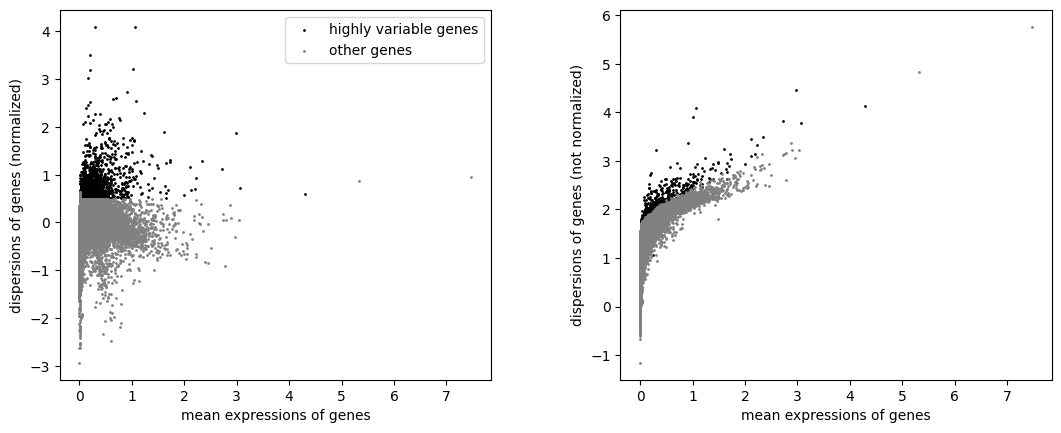

Number of variable genes: 3684


In [21]:
sc.pp.highly_variable_genes(adata, batch_key='batch', min_mean=0.0125, max_mean=5, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

print(f"Number of variable genes: {len(adata.var[adata.var['highly_variable']==True])}")

#### Scale the data and perform PCA.

##### Note: after scaling, it may be useful to regress out some variables (e.g. `sc.pp.regress_out(adata, 'total counts')`) to prevent them from influencing cell clustering.

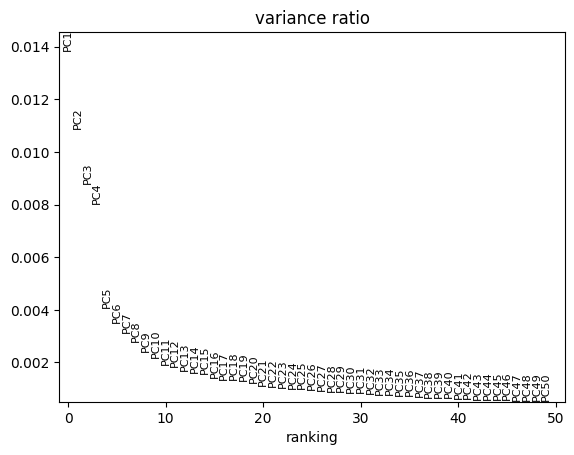

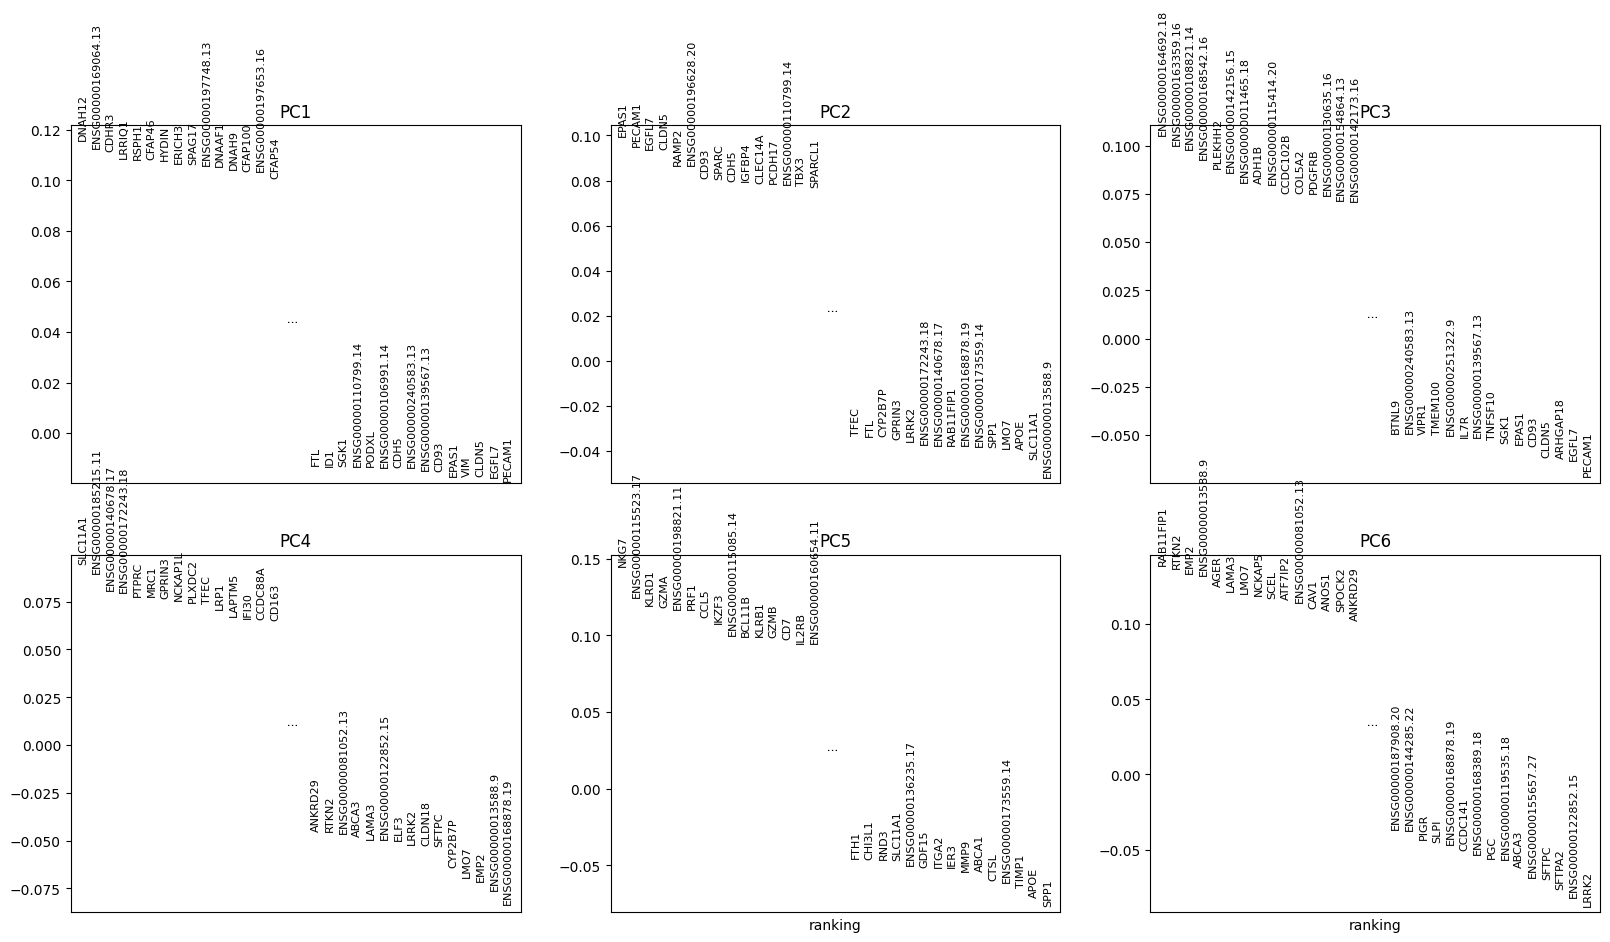

In [22]:
sc.pp.scale(adata)
sc.tl.pca(adata, n_comps=50, svd_solver='arpack', random_state=0)
sc.pl.pca_variance_ratio(adata, n_pcs=50)
sc.pl.pca_loadings(adata, components = '1,2,3,4,5,6')

#### Integrate to adjust the principal components using Harmony. Use the integrated PCs to calculate nearest neighbors.

In [23]:
sc.external.pp.harmony_integrate(adata, key='batch', basis='X_pca', adjusted_basis='X_pca_harmony', max_iter_harmony=20, random_state=0)

sc.pp.neighbors(adata, n_neighbors=30, n_pcs=30, metric = 'euclidean', random_state=0, use_rep='X_pca_harmony')

2025-08-25 21:43:04,808 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-08-25 21:43:24,572 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-08-25 21:43:26,466 - harmonypy - INFO - Iteration 1 of 20
2025-08-25 21:45:18,974 - harmonypy - INFO - Iteration 2 of 20
2025-08-25 21:47:10,610 - harmonypy - INFO - Iteration 3 of 20
2025-08-25 21:49:03,471 - harmonypy - INFO - Iteration 4 of 20
2025-08-25 21:50:49,510 - harmonypy - INFO - Iteration 5 of 20
2025-08-25 21:52:17,519 - harmonypy - INFO - Iteration 6 of 20
2025-08-25 21:53:32,116 - harmonypy - INFO - Iteration 7 of 20
2025-08-25 21:54:48,055 - harmonypy - INFO - Iteration 8 of 20
2025-08-25 21:56:05,956 - harmonypy - INFO - Iteration 9 of 20
2025-08-25 21:57:18,585 - harmonypy - INFO - Iteration 10 of 20
2025-08-25 21:58:28,177 - harmonypy - INFO - Iteration 11 of 20
2025-08-25 21:59:33,467 - harmonypy - INFO - Converged after 11 iterations
2025-08-25 22:01:11.121716: I external/local_xla/

#### Create a UMAP embedding for visualization.

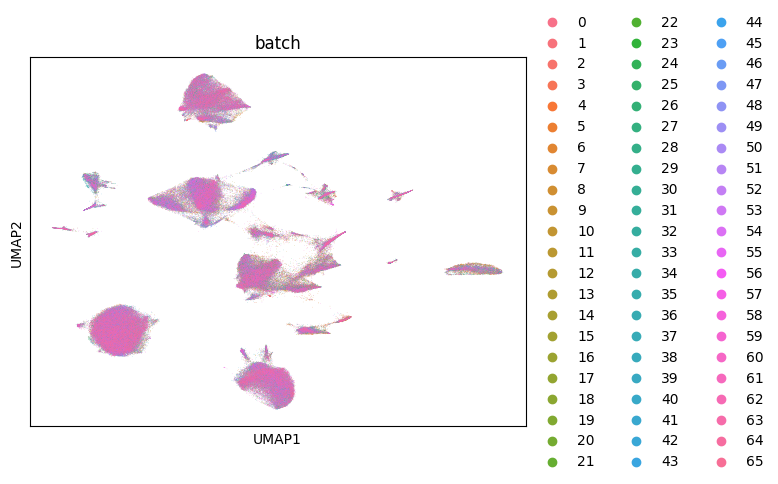

In [24]:
sc.tl.umap(adata, min_dist=0.1)

# Seaborn can provide a nice color palette for visualization

import seaborn as sns

num_batches = len(adata.obs['batch'].unique())

batch_palette = sns.husl_palette(num_batches)

sc.pl.umap(adata, color='batch', palette=batch_palette)

#### Unbiased clustering using the Leiden algorithm can group like cells together.

#### In this vignette, `celltypist` annotation (part 4 below) does not rely on these pre-computed clusters.

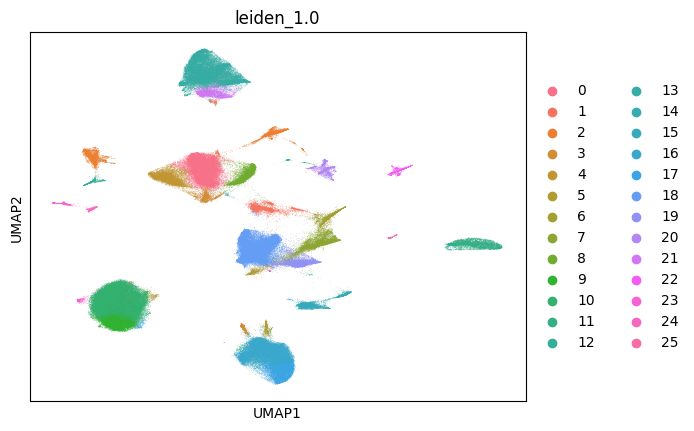

In [25]:
sc.tl.leiden(adata, resolution=1, flavor='igraph', key_added='leiden_1.0')

num_clusters = len(adata.obs['leiden_1.0'].unique())

cluster_palette = sns.husl_palette(num_clusters)

sc.pl.umap(adata, color='leiden_1.0', palette=cluster_palette)

## ***<u>Part 4. Annotation of cell types.<u/>***

#### `celltypist` (Dominguez Conde et al., 2022) is a model-based annotation tool that can be used to predict cell types in sc/snRNA-seq data.

In [26]:
import celltypist
from celltypist import models

#### Use the model derived from the Human Lung Cell Atlas (https://data.humancellatlas.org/hca-bio-networks/lung/atlases/lung-v1-0)

In [27]:
model = models.Model.load(model = 'Human_Lung_Atlas.pkl')
print(model)
print(model.cell_types)

CellTypist model with 61 cell types and 5017 features
    date: 2023-05-17 19:51:55.661237
    details: integrated Human Lung Cell Atlas (HLCA) combining multiple datasets of the healthy respiratory system
    source: https://doi.org/10.1038/s41591-023-02327-2
    version: v2
    cell types: AT0, AT1, ..., pre-TB secretory
    features: TSPAN6, FGR, ..., RP1-34B20.21
['AT0' 'AT1' 'AT2' 'AT2 proliferating' 'Adventitial fibroblasts'
 'Alveolar Mph CCL3+' 'Alveolar Mph MT-positive'
 'Alveolar Mph proliferating' 'Alveolar fibroblasts'
 'Alveolar macrophages' 'B cells' 'Basal resting' 'CD4 T cells'
 'CD8 T cells' 'Classical monocytes' 'Club (nasal)' 'Club (non-nasal)'
 'DC1' 'DC2' 'Deuterosomal' 'EC aerocyte capillary' 'EC arterial'
 'EC general capillary' 'EC venous pulmonary' 'EC venous systemic'
 'Goblet (bronchial)' 'Goblet (nasal)' 'Goblet (subsegmental)'
 'Hematopoietic stem cells' 'Hillock-like' 'Interstitial Mph perivascular'
 'Ionocyte' 'Lymphatic EC differentiating' 'Lymphatic EC 

#### Because `celltypist` relies on log-transformed normalized counts, swap out the current scaled matrix.

In [28]:
adata.layers['scaled'] = adata.X.copy()
adata.X = adata.layers['norm_log1p'].copy()

#### Generate predictions in the data based on the indicated model.

In [29]:
predictions = celltypist.annotate(adata, model = 'Human_Lung_Atlas.pkl', majority_voting = True)

🔬 Input data has 282262 cells and 48082 genes
🔗 Matching reference genes in the model
🧬 4117 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 30
🗳️ Majority voting the predictions
✅ Majority voting done!


#### Map the preditions back onto `adata`.

... storing 'celltypist_prediction' as categorical


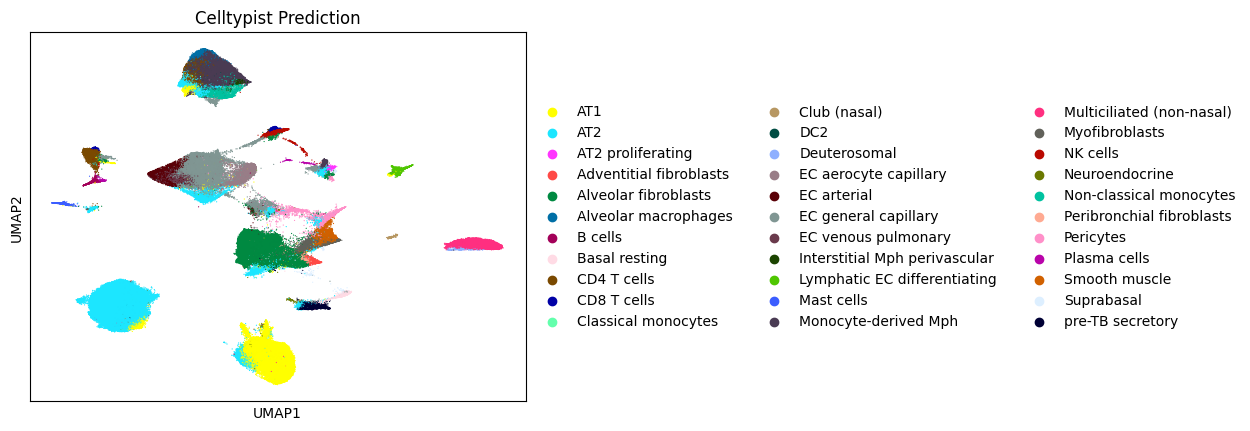

In [30]:
adata.obs['celltypist_prediction'] = adata.obs.index.map(predictions.predicted_labels.to_dict()['majority_voting'])
sc.pl.umap(adata, color='celltypist_prediction', size = 3, title='Celltypist Prediction')

## ***<u>Part 5. Examining the effect of age on cell type composition<u/>***

#### Determine quartile ranges for ages of all donors represented in the dataset here.

In [31]:
boundaries = np.percentile(list(metadata['Age (years)'].astype(float)), [0, 25, 50, 75, 100])
print(boundaries)

[ 0.     1.605 33.5   65.5   90.   ]


#### And divide the data into 4 approximately equal groups by age:

In [32]:
adata.obs['Age_group'] = pd.cut(
    adata.obs['Age (years)'].astype(float),
    bins = boundaries,
    labels = [f'<{round(boundaries[1],1)}', # Youngest group
              f'{round(boundaries[1],1)}-{round(boundaries[2],1)}', # Second quartile group
              f'{round(boundaries[2],1)}-{round(boundaries[3],1)}', # Third quartile group
              f'{round(boundaries[3],1)}+'],  # Oldest group
    include_lowest = True
)

#### For each donor in each age group, determine the cell type composition of the sample.

#### Create a new dataframe (`df`) to hold composition data.

In [33]:
grouped = adata.obs.groupby(['Age_group', 'batch', 'celltypist_prediction']).size().rename('count').reset_index()
totals = adata.obs.groupby(['Age_group','batch']).size().rename('total').reset_index()
df = pd.merge(grouped, totals, on=['Age_group','batch'])
df['proportion'] = df['count'] / df['total']

#### For plotting, calculate the mean and standard deviation of proportions in each group

In [34]:
stats = df.groupby(['Age_group', 'celltypist_prediction'])['proportion'].agg(['mean','std']).reset_index()

#### Subplots in `matplotlib` can be leveraged to create a clean grid representation of proportions across age groups and cell types.

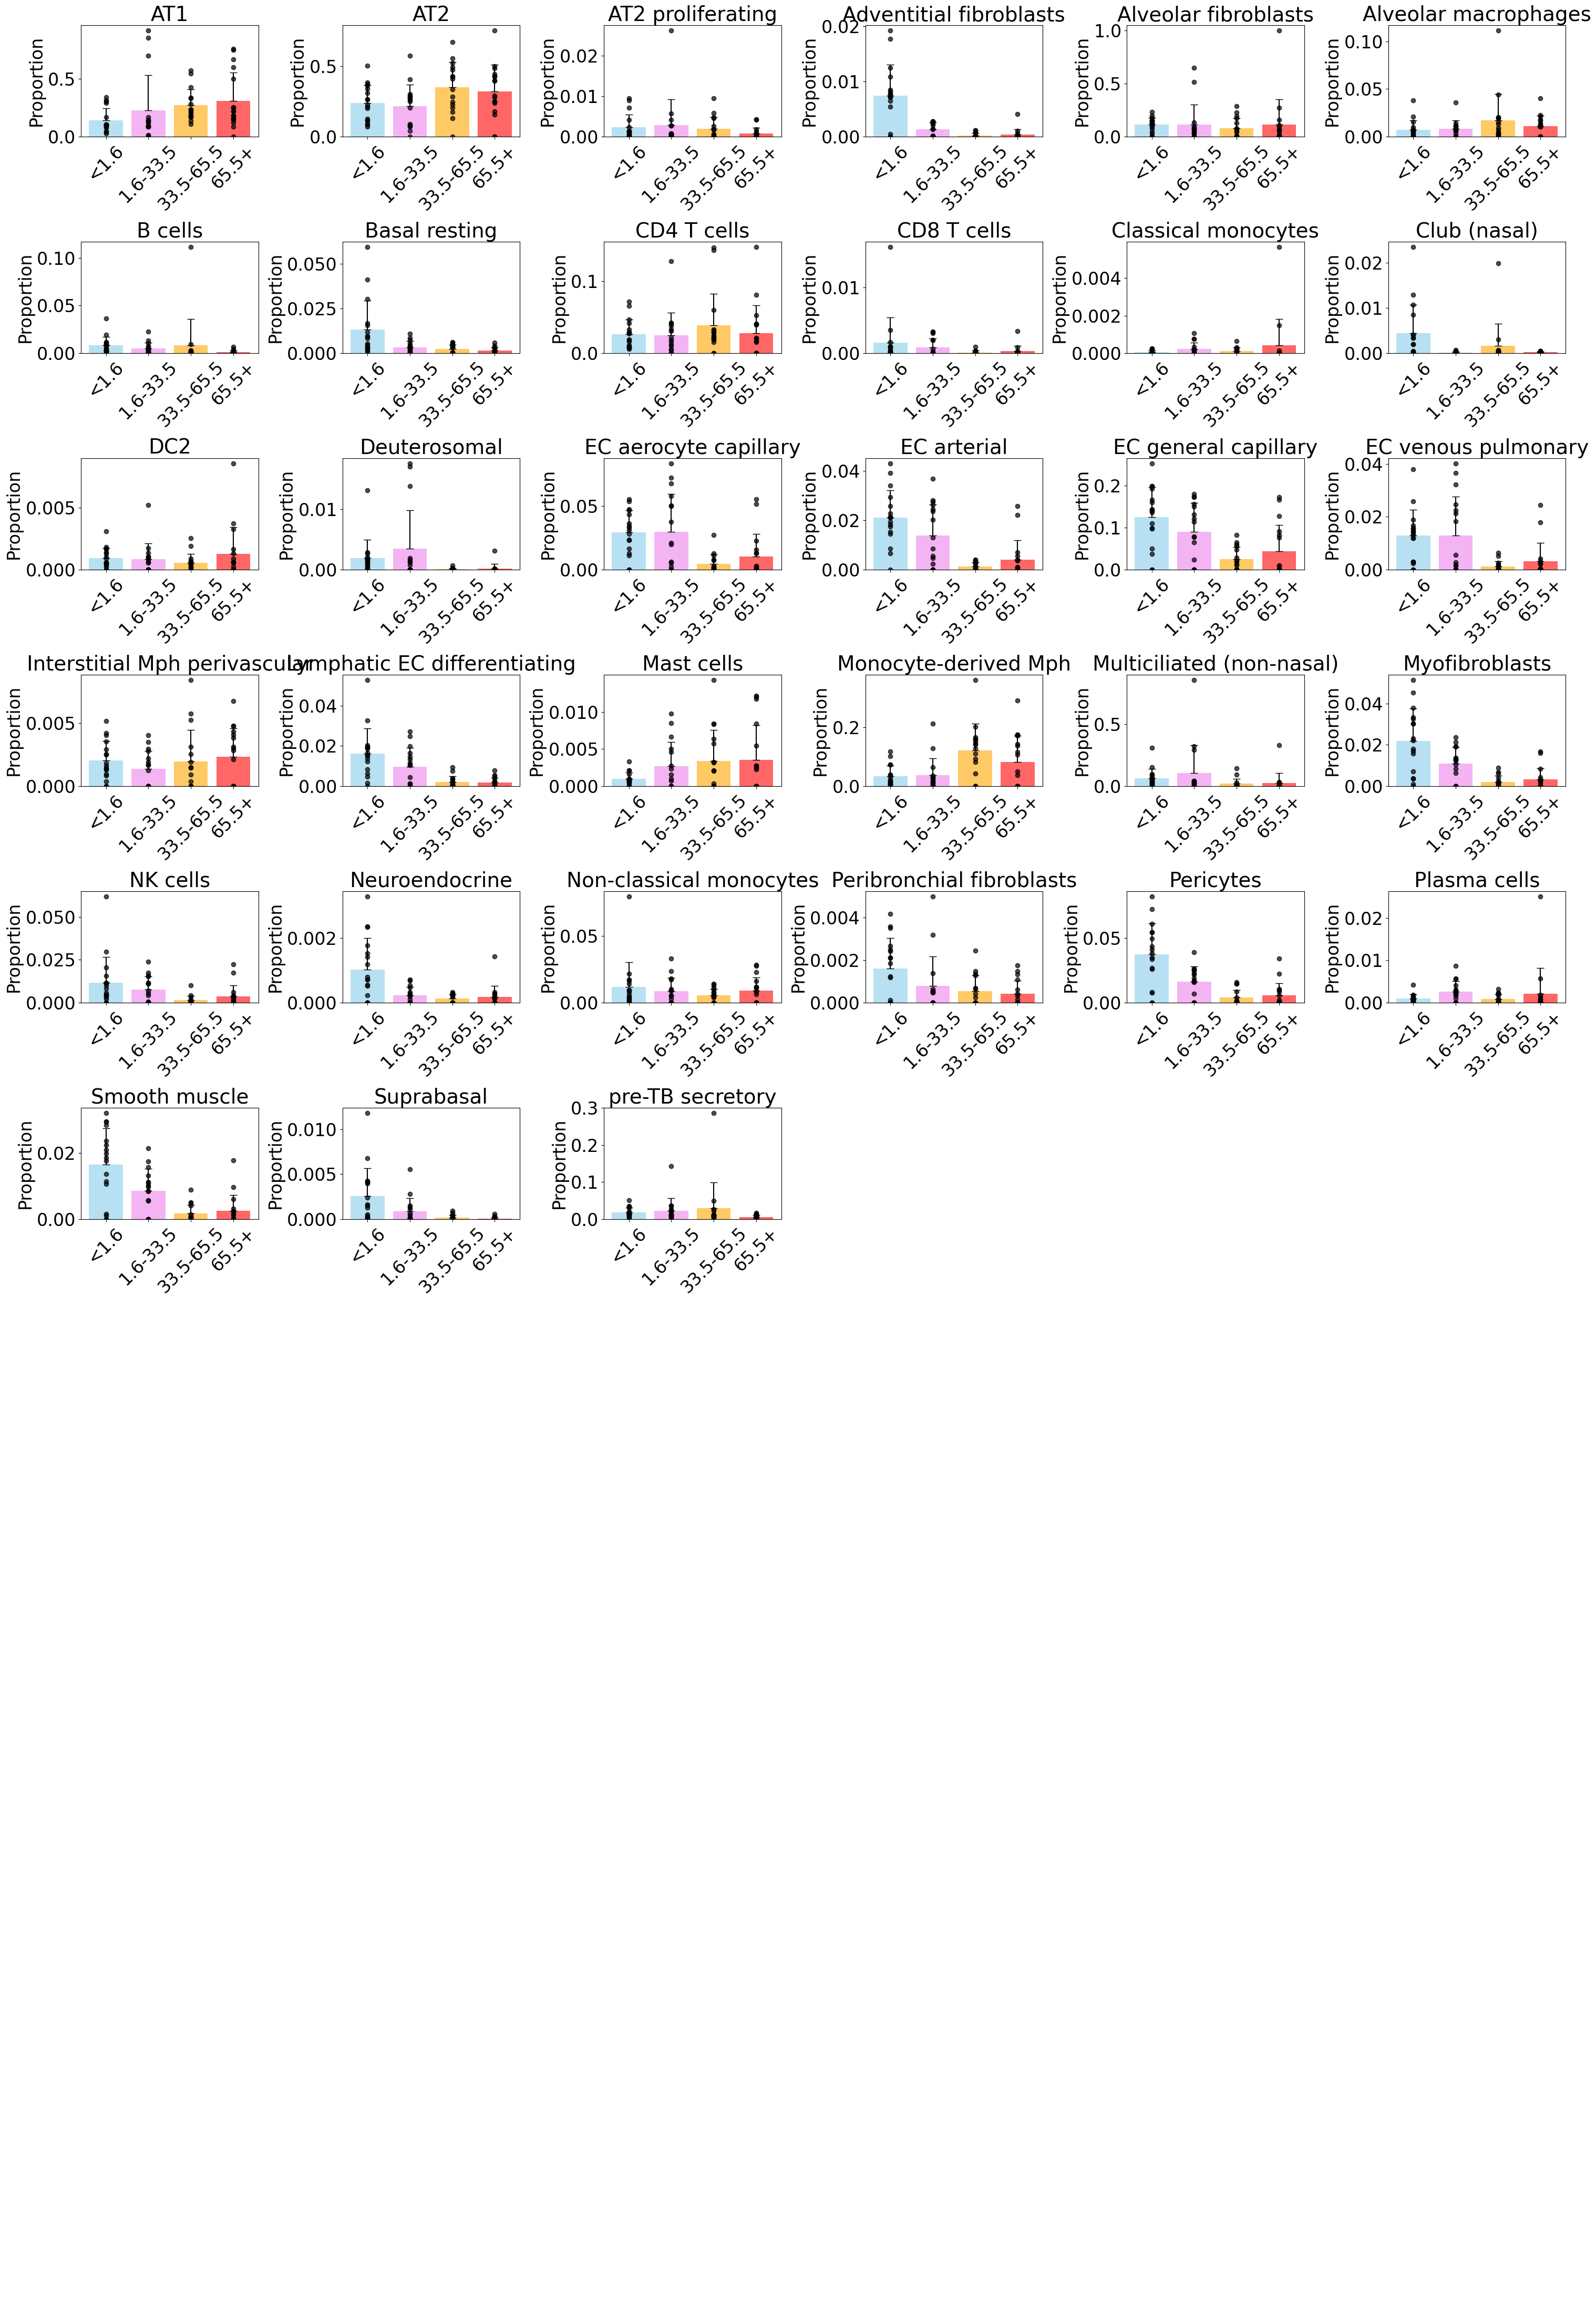

In [35]:
cell_types = df['celltypist_prediction'].unique()
n_cell_types = len(cell_types)
ncols = 6
nrows = 11 # Maximum of 61 total cell types in model (6 columns by 11 rows)

fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
axes = axes.flatten()

# Makes a subplot for each cell type
for i, cell_type in enumerate(cell_types):
    ax = axes[i]
    
    # Subset df and statistics for each cell type
    df_cell_type = df[df['celltypist_prediction']==cell_type]
    stats_cell_type = stats[stats['celltypist_prediction']==cell_type]
    
    # Positive error bars only (negative=0, positive=std)
    err = [np.zeros_like(stats_cell_type['std']), stats_cell_type['std'].values]
    
    # Bar plot representing the mean and positive error bars
    ax.bar(
        stats_cell_type['Age_group'], 
        stats_cell_type['mean'], 
        yerr=err,
        color=['skyblue', 'violet', 'orange', 'red'], 
        alpha=0.6, 
        capsize=5
    )
    
    # Overlay of individual donors in each group
    for age in df_cell_type['Age_group'].unique():
        y = df_cell_type.loc[df_cell_type['Age_group']==age, 'proportion']
        x = [age]*len(y)
        ax.scatter(x, y, color='black', alpha=0.7)
    
    ax.set_title(cell_type, fontsize=28)
    ax.set_ylabel('Proportion', fontsize=24)
    ax.tick_params(axis='x', rotation=45, labelsize=24)
    ax.tick_params(axis='y', labelsize=24)

# Turn off unused axes
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()
plt.close()

# Part 6. Saving the data.

#### Finally, save the annotated & integrated dataset. The resulting file includes all annotations, embeddings, and layers and will be approximately **75 GB**.

In [36]:
# New directory for the concatenated dataset

os.makedirs('lung-single-nuc-data/integrated')

# Save as h5ad

print(f'Writing "{num_batches}-lung-samples-annotated.h5ad" to disk in "lung-single-nuc-data/integrated/"...')
adata.write(f'lung-single-nuc-data/integrated/{num_batches}-lung-samples-annotated.h5ad')
print('Finished!')

Writing "66-lung-samples-annotated.h5ad" to disk in "lung-single-nuc-data/integrated/"...
Finished!
